# Bayes Network with PyAgrum (Added Data)

---------
**Data**  
No encryption, topology: Heavy dumbbell  
- 3 Clients: 6 experiments
- 5 Clients: 6 experiments
- 8 Clients: 3 experiments (only 7 clients send UDP packets for some experiments)
---------

Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as explain

from sklearn.preprocessing import StandardScaler

Define Functions

In [2]:
def preprocess_data(data):
    """
    Process raw data from a dictionary to a formatted DataFrame.
    
    Parameters:
    - data (dict): A dictionary where the key is an IP address and the value is another dictionary
      of statistics indexed by bin number.

    Returns:
    - pd.DataFrame: A DataFrame with rows for each statistic, including IP and bin index, and
      columns reordered excluding the first and last bin index (drop bin number larger than 18 if there are more than 20 bins).
    """
    rows = []
    for ip, stats in data.items():
        for index, values in stats.items():
            # Exclude bins with index 0 or index > 18
            if index == 0 or index > 18:
                continue
            values['IP'] = ip
            values['bin_index'] = index
            rows.append(values)
    
    # Create the DataFrame
    df = pd.DataFrame(rows)

    # Reorder columns
    column_order = ['IP', 'bin_index'] + [col for col in df.columns if col not in ['IP', 'bin_index']]
    df = df[column_order]

    # Reset index after filtering
    df = df.reset_index(drop=True)
    
    return df


def load_and_preprocess(file_path):
    """
    Load data from a pickle file and preprocess it.
    
    Parameters:
    - file_path (str): The file path to the pickle file containing data processed by preprocessing_bins.py
    
    Returns:
    - pd.DataFrame: A preprocessed DataFrame ready for further analysis or processing.
    """
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return preprocess_data(data)

In [3]:
def feature_engineering(df, client_ips):
    """
    Create 'is_speaking' variable using standard deviation of outgoing bytes of a client.
    Calculate outgoing bytes for other clients iterating over each client.
 
    Parameters:
    - df (pd.DataFrame): The original DataFrame containing data for all clients.
    - client_ips (list): A list of IP addresses for all clients.

    Returns:
    - pd.DataFrame: A DataFrame with processed data for each client, concatenated into a single DataFrame.
    """
    df_generalized_list = []
    for client_ip in client_ips:
        # Filter the DataFrame for the current client
        df_filtered = df[df['IP'] == client_ip].copy()

        # Set 'is_speaking' to 1 if the standard outgoing bytes threshold is reached
        df_filtered.loc[df_filtered['std_outgoing_bytes'] >= 20, 'is_speaking'] = 1

        # Initialize a column for 'client_rest_total_bytes_outgoing' with zeros
        df_filtered['client_rest_total_bytes_outgoing'] = 0

        # Sum outgoing bytes from other clients
        for other_client_ip in client_ips:
            if other_client_ip != client_ip:
                outgoing_bytes = df[df['IP'] == other_client_ip]['total_bytes_outgoing'].values
                # Ensure we add only as many elements as exist in df_filtered
                outgoing_bytes_to_add = outgoing_bytes[:len(df_filtered)]
                df_filtered['client_rest_total_bytes_outgoing'] += outgoing_bytes_to_add

        # Keep only the relevant columns
        relevant_columns = ['total_bytes_outgoing', 'average_outgoing_bytes', 'average_incoming_bytes', 'total_bytes_incoming',
                            'client_rest_total_bytes_outgoing', 'is_speaking']
        df_filtered = df_filtered[relevant_columns]

        # Append the processed DataFrame slice to the list
        df_generalized_list.append(df_filtered)

    # Concatenate all the DataFrame slices into one DataFrame
    return pd.concat(df_generalized_list, ignore_index=True)

## 3 Clients

### (a) Load Data

In [4]:
# List of file paths
file_paths_3 = [
    '../data/pickle_files/hdumb_3_false_bins1.pkl',
    '../data/pickle_files/hdumb_3_false_bins2.pkl',
    '../data/pickle_files/hdumb_3_false_bins3.pkl',
    '../data/pickle_files/hdumb_3_false_bins4.pkl',
    '../data/pickle_files/hdumb_3_false_bins5.pkl',
    '../data/pickle_files/hdumb_3_false_bins6.pkl'
]

# Load, preprocess, and collect all dataframes in a list
data_frames_3 = [load_and_preprocess(path) for path in file_paths_3]

# Concatenate all dataframes into one
df_combined_3 = pd.concat(data_frames_3)
df_combined_3.head()

,IP,bin_index,total_bytes_incoming,total_bytes_outgoing,incoming_packets,outgoing_packets,sum_inter_arrival_incoming,count_inter_arrival_incoming,sum_inter_arrival_outgoing,count_inter_arrival_outgoing,average_incoming_bytes,std_incoming_bytes,median_incoming_bytes,packet_frequency_incoming,average_inter_arrival_incoming,average_outgoing_bytes,std_outgoing_bytes,median_outgoing_bytes,packet_frequency_outgoing,average_inter_arrival_outgoing
0,10.0.1.1,1,86779,39866,943,532,9.998707,943,10.012674,532,92.024390,26.879112,79.0,94.3,0.010603,74.936090,8.767538,75.0,53.2,0.018821
1,10.0.1.1,2,79904,39474,834,529,9.999061,834,9.985281,529,95.808153,28.227835,99.0,83.4,0.011989,74.620038,8.419250,76.0,52.9,0.018876
2,10.0.1.1,3,70648,38976,704,535,10.003702,704,10.011403,535,100.352273,29.309275,113.0,70.4,0.014210,72.852336,21.458231,72.0,53.5,0.018713
3,10.0.1.1,4,40509,51054,457,531,9.991360,457,10.001567,531,88.641138,30.115973,82.0,45.7,0.021863,96.146893,26.736822,86.0,53.1,0.018835
4,10.0.1.1,5,22666,58063,325,533,10.007949,325,9.991512,533,69.741538,16.718649,77.0,32.5,0.030794,108.936210,25.429980,119.0,53.3,0.018746


### (b) Preprocess and Extract Features

In [5]:
client_ips_3 = ['10.0.1.1', '10.0.2.1', '10.0.3.1']
df_combined_3['is_speaking'] = 0  # Initialize 'is_speaking' to 0 for all records
df_3 = feature_engineering(df_combined_3, client_ips_3)
df_3

,total_bytes_outgoing,average_outgoing_bytes,average_incoming_bytes,total_bytes_incoming,client_rest_total_bytes_outgoing,is_speaking
0,39866,74.936090,92.024390,86779,97289,0
1,39474,74.620038,95.808153,79904,98213,0
2,38976,72.852336,100.352273,70648,98507,1
3,51054,96.146893,88.641138,40509,86619,1
4,58063,108.936210,69.741538,22666,78472,1
...,...,...,...,...,...,...
319,38865,73.192090,99.343066,81660,101230,0
320,38854,73.033835,101.027778,69103,98488,0
321,38503,72.374060,95.793213,90333,100890,0
322,39770,74.896422,95.898428,79308,98285,0


In [6]:
# Standardization does not make any difference
# scaler = StandardScaler()
# features_to_scale = ['total_bytes_outgoing', 'average_outgoing_bytes', 'total_bytes_incoming', 'client_rest_total_bytes_outgoing']
# df_3[features_to_scale] = scaler.fit_transform(df_3[features_to_scale])

#### Discretize data
Bayesian Networks assumes all the random variables to be discrete.  
Here, we simply segments continous variables into 2 bins (hihg or low) since further segmentation did not seem necessary (after some experimentation.)

In [7]:
df_3['total_bytes_outgoing'] = pd.cut(df_3['total_bytes_outgoing'], 2, labels=['low', 'high'])
df_3['total_bytes_incoming'] = pd.cut(df_3['total_bytes_incoming'], 2, labels=['low', 'high'])
df_3['average_outgoing_bytes'] = pd.cut(df_3['average_outgoing_bytes'], 2, labels=['low', 'high'])
df_3['average_incoming_bytes'] = pd.cut(df_3['average_incoming_bytes'], 2, labels=['low', 'high'])
df_3['client_rest_total_bytes_outgoing'] = pd.cut(df_3['client_rest_total_bytes_outgoing'], 2, labels=['low', 'high'])
df_3

,total_bytes_outgoing,average_outgoing_bytes,average_incoming_bytes,total_bytes_incoming,client_rest_total_bytes_outgoing,is_speaking
0,low,low,high,high,high,0
1,low,low,high,high,high,0
2,low,low,high,high,high,1
3,high,high,high,low,high,1
4,high,high,low,low,low,1
...,...,...,...,...,...,...
319,low,low,high,high,high,0
320,low,low,high,high,high,0
321,low,low,high,high,high,0
322,low,low,high,high,high,0


### (c) Train Bayesian Network Model

In [8]:
bn3 = gum.BayesNet('Net')

# Add nodes
tbo = bn3.add(gum.LabelizedVariable('total_bytes_outgoing', '', ['low', 'high']))
tbi = bn3.add(gum.LabelizedVariable('total_bytes_incoming', '', ['low', 'high']))
# abo = bn.add(gum.LabelizedVariable('average_outgoing_bytes', '', df_generalized['average_outgoing_bytes'].nunique()))
restbo = bn3.add(gum.LabelizedVariable('client_rest_total_bytes_outgoing', '', ['low', 'high']))
is_spk = bn3.add(gum.LabelizedVariable('is_speaking', '', 2)) # Assuming 'is_speaking' is binary

# Define the structure of the network manually (this should be based on your domain knowledge)
bn3.addArc(restbo, tbi)
bn3.addArc(tbo, is_spk)
bn3.addArc(tbi, is_spk)
# bn.addArc(abo, is_spk)

# Use BNLearner to learn the parameters from the CSV data
learner = gum.BNLearner(df_3, bn3)
learner.useSmoothingPrior()
bn3 = learner.learnParameters(bn3.dag())

### (d) Inference

#### Information Graph
- Directed Edges represent mutual information, which measures the degree of dependence between two variables.
- The thickness of a directed indicates the magnitude of mutual information

Mutual Information
$$I(A;B)= H(A) - H(A|B)$$
where $H(A)$ is the entropy for $A$ and $H(A|B)$ is the conditional entropy for $A$ given $B$. The equation can be rewritten as follwing:
$$I(A;B)=\sum_{a, b}P(a, b)log\frac{P(a, b)}{P(a)P(b)}$$
Mutual information between variables A and B quantifies the expected information gain about B upon observing A, and vice versa (symmetric). In Bayesian networks, the dependency between two nodes means that the value of one node provides insights into the value of the other. Therefore, mutual information can reveal whether two nodes are interdependent and the extent of their connection. This information gain can pertain to either variable A or B, highlighting mutual influence within the network.
(https://doi.org/10.1016/S0004-3702(02)00191-1)

In [9]:
explain.showInformation(bn3, {}, size="20")

**Observations**
- Mutual information between `client_rest_total_bytes_outgoing` and `total_bytes_incoming` is high --> High dependency
- Mutual information between `total_bytes_incoming` and `is_speaking` is low --> Low dependency
- Mutual inforamtion between `total_byes_outgoing` and `is_speaking` is moderate --> Moderate dependency

#### Inference with Evidence

Base (no evidence)

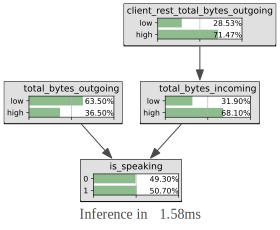

In [10]:
gnb.showInference(bn3, evs={})

Evidence of `total_bytes_outgoing`

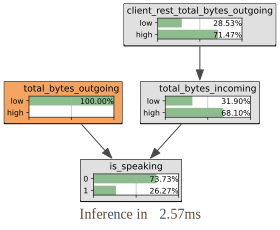

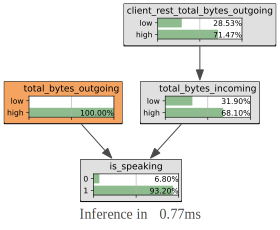

None,None


In [11]:
gnb.sideBySide(gnb.showInference(bn3, evs={'total_bytes_outgoing': 0}), 
               gnb.showInference(bn3, evs={'total_bytes_outgoing': 1}))

Evidence of `client_rest_total_bytes_outgoing`

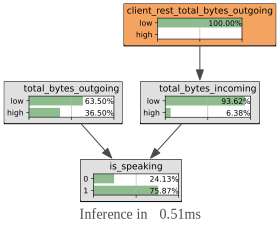

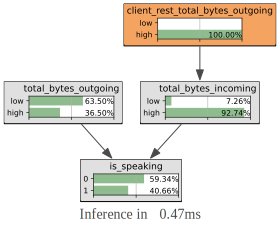

None,None


In [12]:
gnb.sideBySide(gnb.showInference(bn3, evs={'client_rest_total_bytes_outgoing': 0}), 
               gnb.showInference(bn3, evs={'client_rest_total_bytes_outgoing': 1}))

Diagnostic reasoning

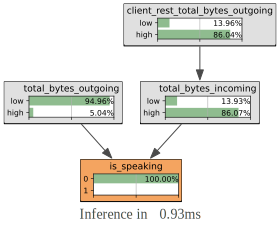

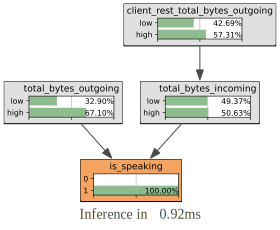

None,None


In [13]:
gnb.sideBySide(gnb.showInference(bn3, evs={'is_speaking': 0}), 
               gnb.showInference(bn3, evs={'is_speaking': 1}))

###### Observations
- $Pr(is \textunderscore speaking|Outgoing Bytes=low)= 26.27\%$ vs $Pr(is \textunderscore speaking|Outgoing Bytes=high)= 93.20\%$
- $Pr(is \textunderscore speaking|Other Client Outgoing Bytes=low)= 75.87\%$ vs $Pr(is \textunderscore speaking|Other Client Outgoing Bytes=high)= 40.66\%$
- Whether a target client is speaking or not is largely dependent on Outgoing Bytes
- Although total bytes incoming is largely dependent on outgoing bytes of other clients, the indirect effect on whether a target client is speaking or not is lower than outgoing bytes of a target client

## 5 Clients

### (a) Load Data

In [14]:
# List of file paths
file_paths_5 = [
    '../data/pickle_files/hdumb_5_false_bins1.pkl',
    '../data/pickle_files/hdumb_5_false_bins2.pkl',
    '../data/pickle_files/hdumb_5_false_bins3.pkl',
    '../data/pickle_files/hdumb_5_false_bins4.pkl',
    '../data/pickle_files/hdumb_5_false_bins5.pkl',
    '../data/pickle_files/hdumb_5_false_bins6.pkl'
]

# Load, preprocess, and collect all dataframes in a list
data_frames_5 = [load_and_preprocess(path) for path in file_paths_5]

# Concatenate all dataframes into one
df_combined_5 = pd.concat(data_frames_5)
df_combined_5.head()

,IP,bin_index,total_bytes_incoming,total_bytes_outgoing,incoming_packets,outgoing_packets,sum_inter_arrival_incoming,count_inter_arrival_incoming,sum_inter_arrival_outgoing,count_inter_arrival_outgoing,average_incoming_bytes,std_incoming_bytes,median_incoming_bytes,packet_frequency_incoming,average_inter_arrival_incoming,average_outgoing_bytes,std_outgoing_bytes,median_outgoing_bytes,packet_frequency_outgoing,average_inter_arrival_outgoing
0,10.0.1.1,1,109030,59281,1286,537,9.967658,1286,9.998009,537,84.782271,23.187361,77.0,128.6,0.007751,110.392924,24.108124,119.0,53.7,0.018618
1,10.0.1.1,2,118455,60858,1390,537,10.011198,1390,9.999053,537,85.219424,22.716776,77.0,139.0,0.007202,113.329609,22.653649,121.0,53.7,0.018620
2,10.0.1.1,3,66670,58393,820,534,10.020594,820,9.997652,534,81.304878,23.526925,77.0,82.0,0.012220,109.350187,24.522055,118.0,53.4,0.018722
3,10.0.1.1,4,58059,59886,733,534,9.985376,733,9.995912,534,79.207367,22.316602,77.0,73.3,0.013623,112.146067,22.543958,120.0,53.4,0.018719
4,10.0.1.1,5,37106,58945,483,537,10.005664,483,10.005954,537,76.824017,23.861636,77.0,48.3,0.020716,109.767225,25.218075,119.0,53.7,0.018633


### (b) Preprocess and Extract Features

In [15]:
client_ips_5 = ['10.0.1.1', '10.0.2.1', '10.0.3.1', '10.0.4.1', '10.0.5.1']
df_combined_5['is_speaking'] = 0  # Initialize 'is_speaking' to 0 for all records
df_5 = feature_engineering(df_combined_5, client_ips_5)
df_5

,total_bytes_outgoing,average_outgoing_bytes,average_incoming_bytes,total_bytes_incoming,client_rest_total_bytes_outgoing,is_speaking
0,59281,110.392924,84.782271,109030,166848,1
1,60858,113.329609,85.219424,118455,169540,1
2,58393,109.350187,81.304878,66670,153084,1
3,59886,112.146067,79.207367,58059,149296,1
4,58945,109.767225,76.824017,37106,145709,1
...,...,...,...,...,...,...
535,39230,73.464419,91.591800,102766,177426,0
536,38561,71.541744,97.838918,75923,175628,0
537,61320,114.831461,72.109091,39660,156154,1
538,58849,110.618421,72.127619,37867,156573,1


In [16]:
df_5['total_bytes_outgoing'] = pd.cut(df_5['total_bytes_outgoing'], 2, labels=['low', 'high'])
df_5['total_bytes_incoming'] = pd.cut(df_5['total_bytes_incoming'], 2, labels=['low', 'high'])
df_5['average_outgoing_bytes'] = pd.cut(df_5['average_outgoing_bytes'], 2, labels=['low', 'high'])
df_5['client_rest_total_bytes_outgoing'] = pd.cut(df_5['client_rest_total_bytes_outgoing'], 2, labels=['low', 'high'])
df_5

,total_bytes_outgoing,average_outgoing_bytes,average_incoming_bytes,total_bytes_incoming,client_rest_total_bytes_outgoing,is_speaking
0,high,high,84.782271,high,low,1
1,high,high,85.219424,high,high,1
2,high,high,81.304878,low,low,1
3,high,high,79.207367,low,low,1
4,high,high,76.824017,low,low,1
...,...,...,...,...,...,...
535,low,low,91.591800,high,high,0
536,low,low,97.838918,low,high,0
537,high,high,72.109091,low,low,1
538,high,high,72.127619,low,low,1


### (c) Train Bayesian Network Model

In [17]:
bn5 = gum.BayesNet('Net')

# Add nodes
tbo = bn5.add(gum.LabelizedVariable('total_bytes_outgoing', '', ['low', 'high']))
tbi = bn5.add(gum.LabelizedVariable('total_bytes_incoming', '', ['low', 'high']))
# abo = bn.add(gum.LabelizedVariable('average_outgoing_bytes', '', df_generalized['average_outgoing_bytes'].nunique()))
restbo = bn5.add(gum.LabelizedVariable('client_rest_total_bytes_outgoing', '', ['low', 'high']))
is_spk = bn5.add(gum.LabelizedVariable('is_speaking', '', 2)) # Assuming 'is_speaking' is binary

# Define the structure of the network manually (this should be based on your domain knowledge)
bn5.addArc(restbo, tbi)
bn5.addArc(tbo, is_spk)
bn5.addArc(tbi, is_spk)
# bn.addArc(abo, is_spk)

# Use BNLearner to learn the parameters from the CSV data
learner = gum.BNLearner(df_5, bn5)
learner.useSmoothingPrior()
bn5 = learner.learnParameters(bn5.dag())

### (d) Inference

#### Information Graph

In [18]:
explain.showInformation(bn5, {}, size="20")

#### Inference with Evidence

Base model (no evidence)

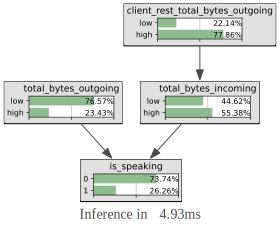

In [19]:
gnb.showInference(bn5, evs={})

Evidence of `total_bytes_outgoing`

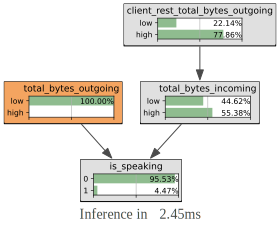

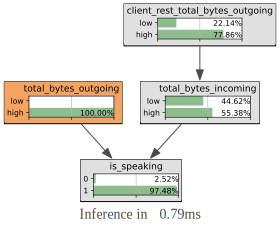

None,None


In [20]:
gnb.sideBySide(gnb.showInference(bn5, evs={'total_bytes_outgoing': 0}), 
               gnb.showInference(bn5, evs={'total_bytes_outgoing': 1}))

Evidence of `client_rest_total_bytes_outgoing`

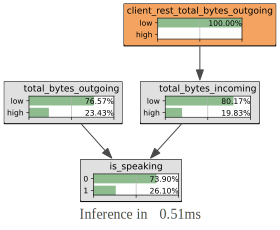

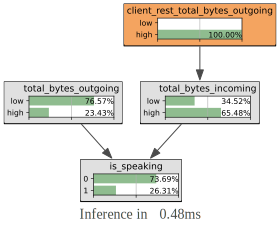

None,None


In [21]:
gnb.sideBySide(gnb.showInference(bn5, evs={'client_rest_total_bytes_outgoing': 0}), 
               gnb.showInference(bn5, evs={'client_rest_total_bytes_outgoing': 1}))

Diagnostic reasoning

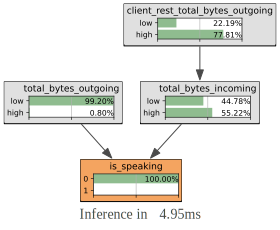

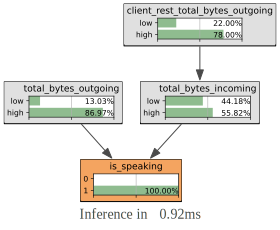

None,None


In [22]:
gnb.sideBySide(gnb.showInference(bn5, evs={'is_speaking': 0}), 
               gnb.showInference(bn5, evs={'is_speaking': 1}))

#### Observations
- Whether a target client is speaking or not is significantly dependent on Outgoing Bytes compared to 3 clients.
- Conditioinal dependency of incoming bytes on outgoing bytes of other clients is less significant than 3 clients.
- Having the evidenc of other cliets does not change the belief (posterior probability) of is_speaking

## 8 Clients

### (a) Load Data

In [23]:
# List of file paths
file_paths_8 = [
    '../data/pickle_files/hdumb_8_false_bins1.pkl',
    '../data/pickle_files/hdumb_8_false_bins2.pkl',
    '../data/pickle_files/hdumb_8_false_bins3.pkl',
    # '../data/pickle_files/hdumb_8_false_bins4.pkl',  # Only 7 distinct IP addresses sending UDP packets
    # '../data/pickle_files/hdumb_8_false_bins5.pkl',  
    # '../data/pickle_files/hdumb_8_false_bins6.pkl'
]

# Load, preprocess, and collect all dataframes in a list
data_frames_8 = [load_and_preprocess(path) for path in file_paths_8]

# Concatenate all dataframes into one
df_combined_8 = pd.concat(data_frames_8)
df_combined_8.head()

,IP,bin_index,total_bytes_incoming,total_bytes_outgoing,incoming_packets,outgoing_packets,sum_inter_arrival_incoming,count_inter_arrival_incoming,sum_inter_arrival_outgoing,count_inter_arrival_outgoing,average_incoming_bytes,std_incoming_bytes,median_incoming_bytes,packet_frequency_incoming,average_inter_arrival_incoming,average_outgoing_bytes,std_outgoing_bytes,median_outgoing_bytes,packet_frequency_outgoing,average_inter_arrival_outgoing
0,10.0.1.1,1,248011,40339,2782,544,10.001760,2782,10.015154,544,89.148454,23.370934,78.0,278.2,0.003595,74.152574,8.908408,76.0,54.4,0.018410
1,10.0.1.1,2,176902,39041,1902,540,9.996716,1902,10.002473,540,93.008412,25.808850,78.0,190.2,0.005256,72.298148,8.252621,72.0,54.0,0.018523
2,10.0.1.1,3,191286,39524,2120,540,10.005140,2120,9.992702,540,90.229245,25.566600,77.0,212.0,0.004719,73.192593,8.710769,72.0,54.0,0.018505
3,10.0.1.1,4,101134,38918,1033,547,9.981451,1033,9.992957,547,97.903195,29.143329,105.0,103.3,0.009663,71.148080,8.890976,72.0,54.7,0.018269
4,10.0.1.1,5,114291,38670,1264,540,10.003696,1264,9.995733,540,90.420095,24.856005,79.0,126.4,0.007914,71.611111,8.234316,72.0,54.0,0.018511


### (b) Preprocess and Extract Features

In [24]:
client_ips_8 = ['10.0.1.1', '10.0.2.1', '10.0.3.1', '10.0.4.1', '10.0.5.1', '10.0.6.1', '10.0.7.1', '10.0.8.1']
df_combined_8['is_speaking'] = 0  # Initialize 'is_speaking' to 0 for all records
df_8 = feature_engineering(df_combined_8, client_ips_8)
df_8

,total_bytes_outgoing,average_outgoing_bytes,average_incoming_bytes,total_bytes_incoming,client_rest_total_bytes_outgoing,is_speaking
0,40339,74.152574,89.148454,248011,316623,0
1,39041,72.298148,93.008412,176902,309048,0
2,39524,73.192593,90.229245,191286,305906,0
3,38918,71.148080,97.903195,101134,287519,0
4,38670,71.611111,90.420095,114291,294038,0
...,...,...,...,...,...,...
427,38959,72.146296,85.977937,155878,297532,0
428,39258,72.165441,87.982641,141916,299425,0
429,38552,71.791434,91.529524,96106,293545,0
430,38893,71.363303,94.658811,92387,294358,0


In [25]:
df_8['total_bytes_outgoing'] = pd.cut(df_8['total_bytes_outgoing'], 2, labels=['low', 'high'])
df_8['total_bytes_incoming'] = pd.cut(df_8['total_bytes_incoming'], 2, labels=['low', 'high'])
df_8['average_outgoing_bytes'] = pd.cut(df_8['average_outgoing_bytes'], 2, labels=['low', 'high'])
df_8['client_rest_total_bytes_outgoing'] = pd.cut(df_8['client_rest_total_bytes_outgoing'], 2, labels=['low', 'high'])

### (c) Train Bayesian Network Model

In [26]:
bn8 = gum.BayesNet('Net')

# Add nodes
tbo = bn8.add(gum.LabelizedVariable('total_bytes_outgoing', '', ['low', 'high']))
tbi = bn8.add(gum.LabelizedVariable('total_bytes_incoming', '', ['low', 'high']))
# abo = bn.add(gum.LabelizedVariable('average_outgoing_bytes', '', df_generalized['average_outgoing_bytes'].nunique()))
restbo = bn8.add(gum.LabelizedVariable('client_rest_total_bytes_outgoing', '', ['low', 'high']))
is_spk = bn8.add(gum.LabelizedVariable('is_speaking', '', 2)) # Assuming 'is_speaking' is binary

# Define the structure of the network manually (this should be based on your domain knowledge)
bn8.addArc(restbo, tbi)
bn8.addArc(tbo, is_spk)
bn8.addArc(tbi, is_spk)
# bn.addArc(abo, is_spk)

# Use BNLearner to learn the parameters from the CSV data
learner = gum.BNLearner(df_8, bn8)
learner.useSmoothingPrior()
bn8 = learner.learnParameters(bn8.dag())

## (d) Inference

#### Information Graph

In [27]:
explain.showInformation(bn8, {}, size="20")

#### Inference with Evidence

Base model (without evidence)

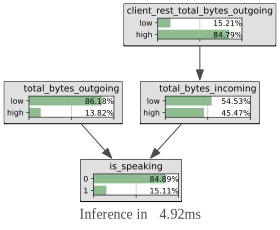

In [28]:
gnb.showInference(bn8, evs={})

Evidence of `total_bytes_outgoing`

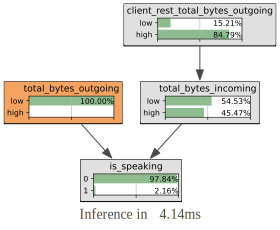

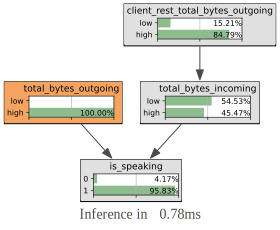

None,None


In [29]:
gnb.sideBySide(gnb.showInference(bn8, evs={'total_bytes_outgoing': 0}), 
               gnb.showInference(bn8, evs={'total_bytes_outgoing': 1}))

Evidence of `client_rest_total_bytes_outgoing`

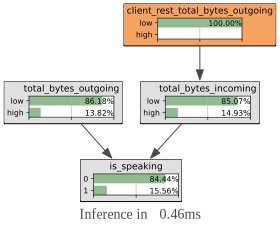

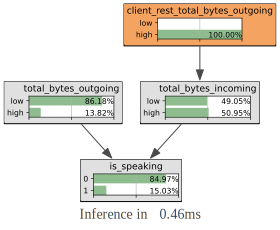

None,None


In [30]:
gnb.sideBySide(gnb.showInference(bn8, evs={'client_rest_total_bytes_outgoing': 0}), 
               gnb.showInference(bn8, evs={'client_rest_total_bytes_outgoing': 1}))

Diagnostic reasoning

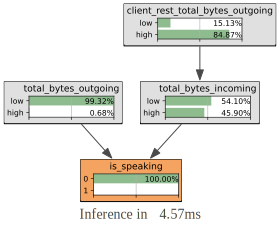

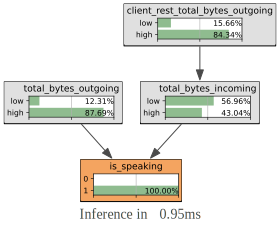

None,None


In [33]:
gnb.sideBySide(gnb.showInference(bn8, evs={'is_speaking': 0}), 
               gnb.showInference(bn8, evs={'is_speaking': 1}))

#### Observations
- Similar to 5 Clients

----------
### Below is some experiments

In [31]:
client_ips_3 = ['10.0.1.1', '10.0.2.1', '10.0.3.1']
df_combined_3['is_speaking'] = 0  # Initialize 'is_speaking' to 0 for all records
df_3 = feature_engineering(df_combined_3, client_ips_3)
df_3

,total_bytes_outgoing,average_outgoing_bytes,average_incoming_bytes,total_bytes_incoming,client_rest_total_bytes_outgoing,is_speaking
0,39866,74.936090,92.024390,86779,97289,0
1,39474,74.620038,95.808153,79904,98213,0
2,38976,72.852336,100.352273,70648,98507,1
3,51054,96.146893,88.641138,40509,86619,1
4,58063,108.936210,69.741538,22666,78472,1
...,...,...,...,...,...,...
319,38865,73.192090,99.343066,81660,101230,0
320,38854,73.033835,101.027778,69103,98488,0
321,38503,72.374060,95.793213,90333,100890,0
322,39770,74.896422,95.898428,79308,98285,0


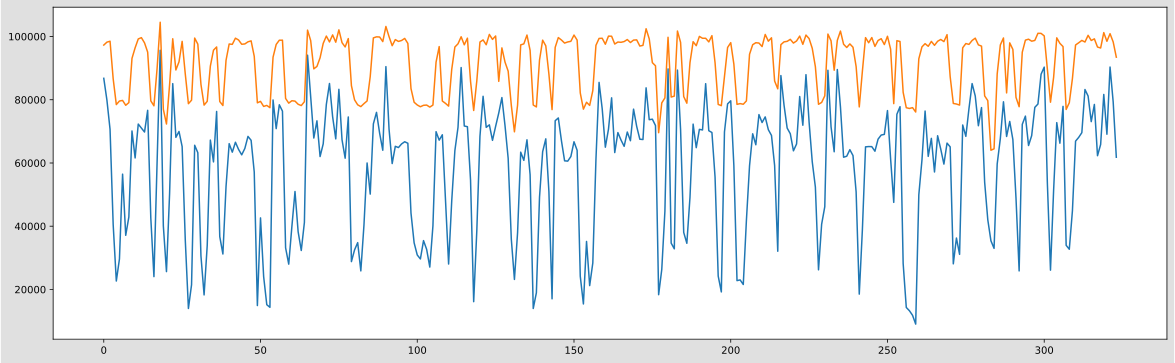

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(df_3['total_bytes_incoming'])
plt.plot(df_3['client_rest_total_bytes_outgoing'])

In [24]:
client_ips_5 = ['10.0.1.1', '10.0.2.1', '10.0.3.1', '10.0.4.1', '10.0.5.1']
df_combined_5['is_speaking'] = 0  # Initialize 'is_speaking' to 0 for all records
df_5 = feature_engineering(df_combined_5, client_ips_5)
df_5

,total_bytes_outgoing,average_outgoing_bytes,total_bytes_incoming,client_rest_total_bytes_outgoing,is_speaking
0,59281,110.392924,109030,166848,1
1,60858,113.329609,118455,169540,1
2,58393,109.350187,66670,153084,1
3,59886,112.146067,58059,149296,1
4,58945,109.767225,37106,145709,1
...,...,...,...,...,...
535,39230,73.464419,102766,177426,0
536,38561,71.541744,75923,175628,0
537,61320,114.831461,39660,156154,1
538,58849,110.618421,37867,156573,1


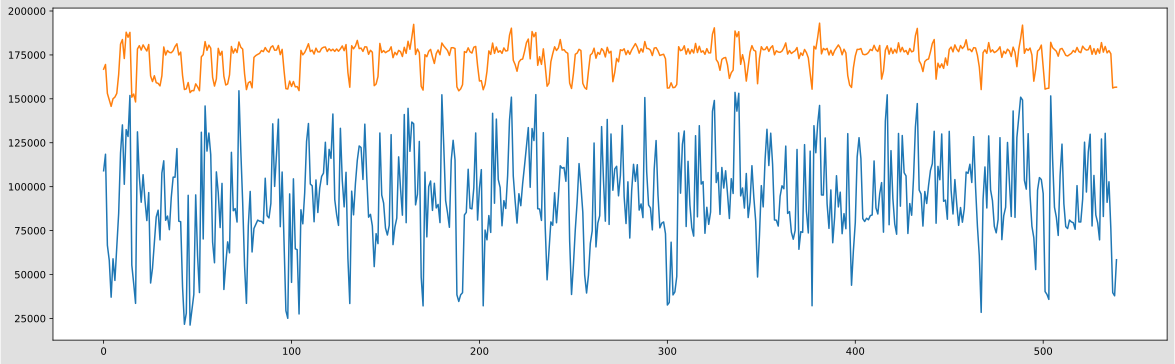

In [25]:
plt.figure(figsize=(20, 6))
plt.plot(df_5['total_bytes_incoming'])
plt.plot(df_5['client_rest_total_bytes_outgoing'])